Link til Hanqing Lu's github: https://github.com/HanqingLu/MultiscaleRNN

### Import packages and activate cuda

In [0]:
import torch, math, time, os
import torch.nn as nn
import torch.optim as optim

from torch.autograd import Variable, Function
from torch.nn import Module, Parameter
from torch.nn.functional import softmax
from torchtext import data
from torchtext import datasets
from torchtext.vocab import GloVe

import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import StepLR

import warnings
warnings.filterwarnings(action='once')

In [2]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

Running GPU.


### Small function and class

In [0]:
#A modification of the simoid function, as described in the article. a defines the slope hard_sigm(x) = max(0,min(1,(ax+1)/2))

def hard_sigm(a, x):
    temp = torch.div(torch.add(torch.mul(x, a), 1), 2.0)
    output = torch.clamp(temp, min=0, max=1)
    return output

In [0]:
class bound(Function):
    def forward(self, x):
        # forward : x -> output
        self.save_for_backward(x)
        output = x > 0.5
        return output.float()

    def backward(self, output_grad):
        # backward: output_grad -> x_grad
        x = self.saved_tensors
        x_grad = None

        if self.needs_input_grad[0]:
            x_grad = output_grad.clone()

        return x_grad

## HM_LSTM network defined by 3 classes (CELL, HMLSTM AND HMLSTM NET)

In [0]:
class HM_LSTMCell(Module):
    def __init__(self, bottom_size, hidden_size, top_size, a, last_layer):
        super(HM_LSTMCell, self).__init__()
        self.bottom_size = bottom_size
        self.hidden_size = hidden_size 
        self.top_size = top_size
        self.a = a #se slope annealing trick i training
        self.last_layer = last_layer


        #Initialize weight matrices for transition of hidden states between HM_LSTM cells
        '''
        U_recur means the state transition parameters from layer l (current layer) to layer l
        U_topdown means the state transition parameters from layer l+1 (top layer) to layer l
        W_bottomup means the state transition parameters from layer l-1 (bottom layer) to layer l
        '''
        self.W_bottomup = Parameter(torch.cuda.FloatTensor(4 * self.hidden_size + 1, self.bottom_size))
        self.U_recur = Parameter(torch.cuda.FloatTensor(4 * self.hidden_size + 1, self.hidden_size))

        if not self.last_layer:
            self.U_topdown = Parameter(torch.cuda.FloatTensor(4 * self.hidden_size + 1, self.top_size))

        self.bias = Parameter(torch.cuda.FloatTensor(4 * self.hidden_size + 1))

        #Perform weight initialization of these 4 (or 3) parameters with function defined below.
        self.reset_parameters()

    #Think about redoing weight initialization: https://erwanscornet.github.io/teaching/RNN.pdf
    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for par in self.parameters():
            par.data.uniform_(-stdv, stdv)

    def forward(self, c, h_bottomup, h_recur, h_topdown, z, z_bottom): 
        # h_bottom.size = bottom_size * batch_size
        """
        c:                  cell state in previous cell (l,t-1)
        h_bottomup:         hidden states in layer below (l-1,t)
        h_recur:            hidden states in previous timestep (l,t-1)
        h_topdown:          hidden states in layer above and previous timestep (l+1,t-1)
        z:                  boundary state in previous time step (l,t-1)
        z_bottom:           boundary state in layer below (l-1,t)

        """
        #Calculate s-matrices to calculate new cell state (COPY,UPDATE or FLUSH)
        s_recur = torch.mm(self.U_recur, h_recur)
        
        s_bottomup_init = torch.mm(self.W_bottomup, h_bottomup)
        s_bottomup = z_bottom.expand_as(s_bottomup_init) * s_bottomup_init

        #If not last layer, calculate s_topdown, else set s_topdown to 0
        if not self.last_layer:
            s_topdown_init = torch.mm(self.U_topdown, h_topdown) 
            s_topdown = z.expand_as(s_topdown_init) * s_topdown_init
        else:
            s_topdown = Variable(torch.zeros(s_recur.size()).cuda(), requires_grad=False).cuda()


        #Extract individual variables (matrix/vector) from the large S matrix (f_s: f_slice) 
        f_s = s_recur + s_topdown + s_bottomup + self.bias.unsqueeze(1).expand_as(s_recur)

        # f_s.size = (4 * hidden_size + 1) * batch_size
        f = torch.sigmoid(f_s[0:self.hidden_size, :])  # hidden_size * batch_size
        i = torch.sigmoid(f_s[self.hidden_size:self.hidden_size*2, :])
        o = torch.sigmoid(f_s[self.hidden_size*2:self.hidden_size*3, :])
        g = torch.tanh(f_s[self.hidden_size*3:self.hidden_size*4, :])
        z_hat = hard_sigm(self.a, f_s[self.hidden_size*4:self.hidden_size*4+1, :])

        #Make vector of ones and resize the boundary states (z-values) to be the same size as the cell parameters (f, i, o and g) 
        one = Variable(torch.ones(f.size()).cuda(), requires_grad=False)
        z = z.expand_as(f)
        z_bottom = z_bottom.expand_as(f)

        #Calculate cell state (one line implementation of out commented if/else below)
        c_new = z * (i * g) + (one - z) * (one - z_bottom) * c + (one - z) * z_bottom * (f * c + i * g) #burde ikke beregnes for ethvert tilfælde? 
        h_new = z * o * torch.tanh(c_new) + (one - z) * (one - z_bottom) * h_recur + (one - z) * z_bottom * o * torch.tanh(c_new)

        # if z == 1: (FLUSH)
        #     c_new = i * g
        #     h_new = o * Func.tanh(c_new)
        # elif z_bottom == 0: (COPY)
        #     c_new = c
        #     h_new = h
        # else: (UPDATE)
        #     c_new = f * c + i * g
        #     h_new = o * Func.tanh(c_new)

        #Saves original x values: both 0, 1 and values in between (found using a), to be used in the backward pass. 
        #Hereafter sets x < 0.5 to 0 and x > 0.5 to 1 as they are used in the forward pass
        z_new = bound()(z_hat)

        return h_new, c_new, z_new

In [0]:
class HM_LSTM(Module): #Istedet for at lave egen LSTM så brug den fra main.py
    def __init__(self, a, input_size, size_list):
        super(HM_LSTM, self).__init__()
        self.a = a
        self.input_size = input_size #bottom_size
        self.size_list = size_list 
        
        """
        input_size:        Input size to network
        size_list[0]:      hidden size of layer 1 aka. input size after embedding
        size_list[1]:      hidden size of layer 2
        size_list[2]:      hidden size of layer 3
        """

        #Init cell state
        self.cell_1 = HM_LSTMCell(self.input_size, self.size_list[0], self.size_list[1], self.a, False) #bottom_size, hidden_size, top_size, a, last_layer
        self.cell_2 = HM_LSTMCell(self.size_list[0], self.size_list[1], self.size_list[2], self.a, False)
        self.cell_3 = HM_LSTMCell(self.size_list[1], self.size_list[2], None, self.a, True)

    def forward(self, inputs, hidden): #hidden state supplied, if the model is going to freestyle or make predictions that dont start from 0
        # inputs.size = (batch_size, time steps, embed_size/input_size) 

        time_steps = inputs.size(1)
        batch_size = inputs.size(0)

        if hidden == None:
            #Layer 1
            h_t1 = Variable(torch.zeros(self.size_list[0], batch_size).float().cuda(), requires_grad=False)
            c_t1 = Variable(torch.zeros(self.size_list[0], batch_size).float().cuda(), requires_grad=False)
            z_t1 = Variable(torch.zeros(1, batch_size).float().cuda(), requires_grad=False)
            #Layer 2
            h_t2 = Variable(torch.zeros(self.size_list[1], batch_size).float().cuda(), requires_grad=False)
            c_t2 = Variable(torch.zeros(self.size_list[1], batch_size).float().cuda(), requires_grad=False)
            z_t2 = Variable(torch.zeros(1, batch_size).float().cuda(), requires_grad=False)
            #Layer 3
            h_t3 = Variable(torch.zeros(self.size_list[2], batch_size).float().cuda(), requires_grad=False)
            c_t3 = Variable(torch.zeros(self.size_list[2], batch_size).float().cuda(), requires_grad=False)
            z_t3 = Variable(torch.zeros(1, batch_size).float().cuda(), requires_grad=False)
        else:
            (h_t1, c_t1, z_t1, h_t2, c_t2, z_t2, h_t3, c_t3, z_t3) = hidden

        #Make vector of ones with the same size as batch, so that input is always passed via s_bottomup (see HMLSTMCell)
        z_one = Variable(torch.ones(1, batch_size).float().cuda(), requires_grad=False)
        
        """
        h_t1:     hidden states of layer 1 at previous timestep (updates to current in each iteration)
        h_t2:     hidden states of layer 2 at previous timestep (updates to current timestep in each iteration)
        h_t3:     hidden states of layer 3 --||--
        z_1:      boundary state of layer 1 --||--
        z_2:      boundary state of layer 2 --||--
        z_3:      boundary state of layer 3 --||--
        """

        h_1, h_2, h_3, z_1, z_2, z_3 = [], [], [], [], [], [] 


        for t in range(time_steps):
            h_t1, c_t1, z_t1 = self.cell_1(c=c_t1, h_bottomup=inputs[:,t, :].t(), h_recur=h_t1, h_topdown=h_t2, z=z_t1, z_bottom=z_one) #t1 og t2 is layer1 and layer2 and not time1 and time2
            h_t2, c_t2, z_t2 = self.cell_2(c=c_t2, h_bottomup=h_t1, h_recur=h_t2, h_topdown=h_t3, z=z_t2, z_bottom=z_t1)  
            h_t3, c_t3, z_t3 = self.cell_3(c=c_t3, h_bottomup=h_t2, h_recur=h_t3, h_topdown=None, z=z_t3, z_bottom=z_t2)  

            h_1 += [h_t1.t()]
            h_2 += [h_t2.t()]
            h_3 += [h_t3.t()]
            z_1 += [z_t1.t()]
            z_2 += [z_t2.t()]
            z_3 += [z_t2.t()]

        hidden = (h_t1, c_t1, z_t1, h_t2, c_t2, z_t2, h_t3, c_t3, z_t3)
        return torch.stack(h_1, dim=1), torch.stack(h_2, dim=1), torch.stack(h_3, dim=1), torch.stack(z_1, dim=1), torch.stack(z_2, dim=1), torch.stack(z_3, dim=1), hidden


In [0]:
class HM_Net(Module):
    def __init__(self, a, size_list, dict_size, embed_size):
        super(HM_Net, self).__init__()
        self.dict_size = dict_size # Vocab size
        self.size_list = size_list # Number of hidden units in each layer
        self.embed_in = nn.Embedding(dict_size, embed_size) #dict_size, embed_size
        self.HM_LSTM = HM_LSTM(a, embed_size, size_list)
        self.weight = nn.Linear(size_list[0]+size_list[1]+size_list[2],3)
        self.embed_out1 = nn.Linear(size_list[0], dict_size)
        self.embed_out2 = nn.Linear(size_list[1], dict_size)
        self.embed_out3 = nn.Linear(size_list[2], dict_size)
        self.relu = nn.ReLU()
        self.loss = nn.CrossEntropyLoss()

    def forward(self, inputs, target, hidden):
        # inputs : batch_size * time_steps
  
        #Embedding
        emb = self.embed_in(inputs)  # batch_size * time_steps * embed_size

        #Initialize network and do forward pass
        h_1, h_2, h_3, z_1, z_2, z_3, hidden = self.HM_LSTM(emb, hidden)  # batch_size * time_steps * hidden_size

        h = torch.cat((h_1, h_2, h_3), 2) #Applied as a 3D tensor. 


        #Do FFNN throuch weights g1 and g2 to h_e which acts as predictor of x_(t+1). 
        #h: Dim: batch, seq len,  total units in hidden layer
        g = torch.sigmoid(self.weight(h.view(h.size(0)*h.size(1), h.size(2)))) # This g is not the LSTM g, but the g combining the different hidden states to predict the outputs
        g_1 = g[:, 0:1]  # batch_size * time_steps, 1
        g_2 = g[:, 1:2]
        g_3 = g[:, 2:3]

        h_e1 = g_1.expand(g_1.size(0), self.dict_size)*self.embed_out1(h_1.view(h_1.size(0)*h_1.size(1), h_1.size(2)))  
        h_e2 = g_2.expand(g_2.size(0), self.dict_size)*self.embed_out2(h_2.view(h_2.size(0)*h_2.size(1), h_2.size(2)))
        h_e3 = g_3.expand(g_3.size(0), self.dict_size)*self.embed_out3(h_3.view(h_3.size(0)*h_3.size(1), h_3.size(2)))

        h_e = self.relu(h_e1 + h_e2 + h_e3)  # batch_size*time_steps, hidden_size
        output = h_e

        batch_loss = self.loss(output, target) # Variable(target)

        return batch_loss, hidden, output, z_1, z_2, z_3

    def init_hidden(self, batch_size):
        #Layer 1
        h_t1 = Variable(torch.zeros(self.size_list[0], batch_size).float().cuda(), requires_grad=False)
        c_t1 = Variable(torch.zeros(self.size_list[0], batch_size).float().cuda(), requires_grad=False)
        z_t1 = Variable(torch.zeros(1, batch_size).float().cuda(), requires_grad=False)
        # Layer 2
        h_t2 = Variable(torch.zeros(self.size_list[1], batch_size).float().cuda(), requires_grad=False)
        c_t2 = Variable(torch.zeros(self.size_list[1], batch_size).float().cuda(), requires_grad=False)
        z_t2 = Variable(torch.zeros(1, batch_size).float().cuda(), requires_grad=False)
        # Layer 3
        h_t3 = Variable(torch.zeros(self.size_list[2], batch_size).float().cuda(), requires_grad=False)
        c_t3 = Variable(torch.zeros(self.size_list[2], batch_size).float().cuda(), requires_grad=False)
        z_t3 = Variable(torch.zeros(1, batch_size).float().cuda(), requires_grad=False)

        hidden = (h_t1, c_t1, z_t1, h_t2, c_t2, z_t2, h_t3, c_t3, z_t3 )
        return hidden

### Load data and activate cuda

In [8]:
#Tokenizer: splits sentences into char tokens
def tokenize(lines):
    return [line for line in lines]

# set up fields
TEXT = data.Field(lower=True, tokenize=tokenize, batch_first=True)

# make splits for data
train, valid, test = datasets.PennTreebank.splits(TEXT)

# print information about the data
print('train.fields', train.fields)
print('len(train)', len(train))
print('vars(train[0])', vars(train[0])['text'][0:10])

# build the vocabulary
TEXT.build_vocab(train) # Try with random initialization

# print vocab information
print('len(TEXT.vocab)', len(TEXT.vocab))

# make iterator for splits
train_iter, valid_iter, test_iter = data.BPTTIterator.splits(
    (train, valid, test), batch_size=64, bptt_len=100, device="cuda:0")

# print batch information
batch = next(iter(train_iter))
#print(batch.text)
#print(batch.target)

train.fields {'text': <torchtext.data.field.Field object at 0x7f20d7d0b7b8>}
len(train) 1
vars(train[0]) [' ', 'a', 'e', 'r', ' ', 'b', 'a', 'n', 'k', 'n']
len(TEXT.vocab) 51


### Initialization of hyperparameters for training loop

In [0]:
model_params = locals().copy()

train_data = train_iter
val_data = valid_iter
test_data = test_iter
dict_size = len(TEXT.vocab) #len(corpus.dictionary) # vocab_size 
model_params['dict_size'] = dict_size

# Hyper-parameters
num_epochs = 4

#size_list = [hidden size of layer 1, hidden size of layer 2]
size_list = [256, 256, 256] 
embed_size = 128
model = HM_Net(1.0, size_list, dict_size, embed_size) # size_list = Number of hidden units in each layer a = 1.0
model = model.cuda()

learning_rate = 0.01
optimizer = optim.Adam(model.parameters(), lr=learning_rate) 

# Add learning rate decay
scheduler = StepLR(optimizer, step_size=5, gamma=0.8)

it = 0
start_time = time.time()
bestPPL = 100000
break_flag = False
batch_size=64

#indsat 25. november:
clip=1

# Track loss
training_loss, validation_loss = [], []
loss_list = []


### Training loop

Starting model with following parameters:
Embed dim: 128
Hidden dim: [256, 256, 256]
start training epoch  1 with learning rate: [0.01]
Starting validation data


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


100 Train
200 Train
300 Train
400 Train
500 Train
600 Train
700 Train
--------annealing slope a to 1.2000000000000002
Epoch:  1 finished. Time elapsed: 77.9268626968066 minutes
training loss: 1.2489799438861378
validation loss: 1.293416182200114
start training epoch  2 with learning rate: [0.008]
Starting validation data
100 Train
200 Train
300 Train
400 Train
500 Train
600 Train
700 Train
--------annealing slope a to 1.2400000000000002
Epoch:  2 finished. Time elapsed: 93.63988607724508 minutes
training loss: 1.2181413473939537
validation loss: 1.2740598633175804
start training epoch  3 with learning rate: [0.008]
Starting validation data
100 Train
200 Train
300 Train
400 Train
500 Train
600 Train
700 Train
--------annealing slope a to 1.2800000000000002
Epoch:  3 finished. Time elapsed: 109.36534119049708 minutes
training loss: 1.2068926034714644
validation loss: 1.2500217831324016
start training epoch  4 with learning rate: [0.008]
Starting validation data
100 Train
200 Train
300 Tr

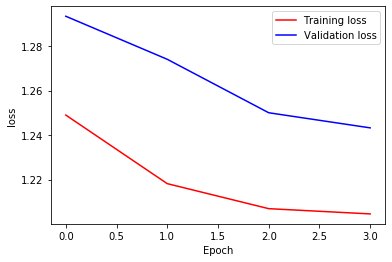

In [15]:
# Track loss
training_loss, validation_loss = [], []
loss_list = []

print('Starting model with following parameters:')
print('Embed dim:', embed_size)
print('Hidden dim:', size_list)

# For each epoch
for epoch in range(num_epochs):
    print("start training epoch ", str(epoch+1), 'with learning rate:', scheduler.get_lr())

    hidden_init = model.init_hidden(batch_size)

    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    i = 0
    model.eval()
        
    # For each sentence in validation set
    print('Starting validation data')
    for batch in val_data:

        hidden = hidden_init

        inputs = batch.text
        inputs = inputs.T

        target = batch.target
        target = target.T
        target = target.reshape(-1)
        
        # Forward pass
        loss, hidden, output, z1, z2, z3 = model(inputs, target, hidden)
        
        # Update loss
        epoch_validation_loss += loss.detach().cpu().data.numpy()

        #evt. hvis memory stadigvæk bliver fyldt
        #del target, del hidden, del loss

    model.train()
    i = 0
    for batch in train_data:
        i += 1
        if i%100 == 0:
            print(i,"Train")

        hidden = hidden_init
        
        optimizer.zero_grad()  # 0.0001s used

        inputs = batch.text
        inputs = inputs.T

        target = batch.target
        target = target.T
        target = target.reshape(-1)
               
        loss, hidden, output, z1, z2, z3 = model(inputs, target, hidden) #tager til forward (inputs, target, hidden)
        loss.backward()  # 3s used
        nn.utils.clip_grad_norm(model.parameters(), clip)
        optimizer.step()  # 0.001s used


        # Update loss
        epoch_training_loss += loss.detach().cpu().data.numpy()
        
        #evt. hvis memory stadigvæk bliver fyldt
        #del target, del hidden, del loss

    # slope annealing trick
    scheduler.step()
    model.HM_LSTM.cell_1.a += 0.04
    model.HM_LSTM.cell_2.a += 0.04
    print("--------annealing slope a to", model.HM_LSTM.cell_1.a)
    print('Epoch: ', epoch+1, 'finished. Time elapsed:', (time.time() - start_time)/60, 'minutes')
    print('training loss:', epoch_training_loss / len(train_data))
    print('validation loss:', epoch_validation_loss / len(val_data))

    # Save loss for plot
    training_loss.append(epoch_training_loss / len(train_data))
    validation_loss.append(epoch_validation_loss / len(val_data))


# Plot training and validation loss of training and validation batches
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('loss')
plt.show()

In [11]:
  
# Get first sentence in test set
loss_list = []
BPC_list = []
j=0
total_loss = 0
it = 0

for batch in test_data:
    hidden = hidden_init

    inputs = batch.text.T
    target = batch.target.T
    target = target.reshape(-1)

    loss, hidden, output, z1, z2, z3 = model.forward(inputs, target, hidden)  
    
    total_loss += loss.detach().cpu().data.numpy() #tester lige 
    it += 1

    loss_list.append(loss.detach().cpu().data.numpy())

    target_array = target.cpu().data.numpy()
    # Bad way of doing BPC
    #outputs_softmax = softmax(output) #BPC kræver log2 og pytorchs softmax bruger den naturlige log. Derfor kan man ikke tage mean af cross entropy
    
    #output_softmax_array = outputs_softmax.cpu().data.numpy()
    
    #summation = 0
    #for i in range(0,len(target_array)):
    #    prob_of_true = output_softmax_array[i][target_array[i]]
    #    summation += np.log2(prob_of_true)
    #BPC_list.append(- 1 / len(target_array) * summation)
    j += 1
    if j == 70:
        break

print('mean of BPC:', np.mean(loss_list/np.log(2)))

/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


mean of BPC: 1.8167461


In [12]:
# Prediction
z1_array = z1.view(-1, 100*64)
z1_array = z1_array.cpu().data.numpy()

z2_array = z2.view(-1, 64*100)
z2_array = z2_array.cpu().data.numpy()

z3_array = z3.view(-1, 64*100)
z3_array = z3_array.cpu().data.numpy()

l1_state, l2_state, l3_state = 'EMPTY', 'EMPTY', 'EMPTY'

output_array = output.cpu().data.numpy()
for i in range(0,200,1):
    #predict
    char_vector = output_array[i]
    char = np.argmax(char_vector)
    predict_char = TEXT.vocab.itos[char]

    # True
    char = target_array[i]
    true_char = TEXT.vocab.itos[char]

    if i > 0:
      # layer 1
      if z1_array[0, i-1] == 1:
        l1_state = 'FLUSH' # Flush
      else:
        l1_state = 'UPDATE' # update

      # Layer 2
      if z2_array[0, i-1] == 1:
        l2_state = 'FLUSH' # Flush
      elif z2_array[0, i-1] == 0 and z1_array[0, i] == 0:
        l2_state = 'COPY' # Copy
      elif z2_array[0, i-1] == 0 and z1_array[0, i] == 1:
        l2_state = 'UPDATE' # update
      
      # Layer 3
      if z3_array[0, i-1] == 1:
        l3_state = 'FLUSH' # Flush
      elif z3_array[0, i-1] == 0 and z2_array[0, i] == 0:
        l3_state = 'COPY' # Copy
      elif z3_array[0, i-1] == 0 and z2_array[0, i] == 1:
        l3_state = 'UPDATE' # update
    
    print(true_char, predict_char, l1_state, l2_state, l3_state, sep='\t')

n	n	EMPTY	EMPTY	EMPTY
g	g	UPDATE	COPY	COPY
i	 	UPDATE	COPY	COPY
n	n	UPDATE	COPY	COPY
g	g	UPDATE	COPY	COPY
 	 	UPDATE	COPY	COPY
t	t	UPDATE	COPY	COPY
h	h	UPDATE	COPY	COPY
e	e	UPDATE	COPY	COPY
i	 	UPDATE	COPY	COPY
r	r	UPDATE	COPY	COPY
 	 	UPDATE	COPY	COPY
b	c	UPDATE	COPY	COPY
r	u	UPDATE	COPY	COPY
o	i	UPDATE	COPY	COPY
k	t	UPDATE	COPY	COPY
e	e	UPDATE	COPY	COPY
r	r	UPDATE	COPY	COPY
s	a	UPDATE	COPY	COPY
 	 	UPDATE	COPY	COPY
w	a	UPDATE	COPY	COPY
o	i	UPDATE	COPY	COPY
n	u	UPDATE	COPY	COPY
d	d	UPDATE	COPY	COPY
e	e	UPDATE	COPY	COPY
r	r	UPDATE	COPY	COPY
i	 	UPDATE	COPY	COPY
n	n	UPDATE	COPY	COPY
g	g	UPDATE	COPY	COPY
 	 	UPDATE	COPY	COPY
w	t	UPDATE	COPY	COPY
h	i	UPDATE	COPY	COPY
e	i	UPDATE	COPY	COPY
t	n	UPDATE	COPY	COPY
h	h	UPDATE	COPY	COPY
e	e	UPDATE	COPY	COPY
r	r	UPDATE	COPY	COPY
 	 	UPDATE	COPY	COPY
a	t	UPDATE	COPY	COPY
n	 	UPDATE	COPY	COPY
o	 	UPDATE	COPY	COPY
t	t	UPDATE	COPY	COPY
h	h	UPDATE	COPY	COPY
e	e	UPDATE	COPY	COPY
r	r	UPDATE	COPY	COPY
 	 	UPDATE	COPY	COPY
c	p	UPDATE	COPY	COPY
r	o	UPDATE	C

In [13]:
# Generation of text

# Convert text to numeric input
input_text = 'new'
input_text = list(input_text)

text_numeric = []

for char in input_text:
  text_numeric.append(TEXT.vocab.stoi[char])


# Run through model
num_generations = 100
input_array = np.array(text_numeric)

hidden_init = model.init_hidden(1)
hidden = hidden_init

exp_dim = len(input_array)

input_tensor = torch.from_numpy(input_array)
input_tensor = input_tensor.expand(1,exp_dim)
input_tensor = input_tensor.view(exp_dim,-1)
input_tensor = input_tensor.T
input_tensor = input_tensor.cuda()

target_tensor = torch.ones(exp_dim).long().cuda()
loss, hidden, outputs, z1, z2, z3 = model.forward(input_tensor,target_tensor, hidden)

values, indices = outputs[-1].max(0)

input_array = np.append(input_array, indices.cpu().numpy())

for i in range(num_generations):
  hidden_init = model.init_hidden(1)
  hidden = hidden_init
  exp_dim = len(input_array)
  input_tensor = torch.from_numpy(input_array)
  input_tensor = input_tensor.expand(1,exp_dim)
  input_tensor = input_tensor.view(exp_dim,-1)
  input_tensor = input_tensor.T
  input_tensor = input_tensor.cuda()
  target_tensor = torch.ones(exp_dim).long().cuda()
  loss, hidden, outputs, z1, z2, z3 = model.forward(input_tensor,target_tensor, hidden)

  values, indices = outputs[-1].max(0)

  input_array = np.append(input_array, indices.cpu().numpy())

/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


In [14]:
predicted_sentence = list() 
for char in input_array:
  predict_char = TEXT.vocab.itos[char]
  predicted_sentence.append(predict_char)

print(''.join(predicted_sentence))

new a <unk> and the company as a <unk> and the company as a <unk> and the company as a <unk> and the com
